In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.append('../creme/')
import utils
import glob
import pandas as pd
import numpy as np
import itertools, os
from scipy.stats import pearsonr
from matplotlib.ticker import MaxNLocator, FormatStrFormatter

2024-02-22 10:03:09.291575: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
cell_lines = [4824, 5110, 5111]
cell_line_names = ['PC-3', 'GM12878', 'K562']
bin_index = [447, 448]
model_name = 'enformer'
pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/context/')
summary_csv_dir = "../results/summary_csvs/enformer"

In [11]:
summary_combined = pd.read_csv(f'{summary_csv_dir}/context_dependence_test.csv')

In [12]:
N_per_category = []
for k, df in summary_combined.groupby('cell_line'):  # per cell line
    context_df = df[(df['context'] != 'other') & (df['context'] != 'other1')]  # remove unclassified contexts
    for context_type, one_context_df in context_df.groupby('context'):
        N = one_context_df.shape[0]
        if N > 200:
            N_after = 200
        else:
            N_after = N
        N_per_category.append([k, context_type, N, N_after])

In [13]:
N_per_category = pd.DataFrame(N_per_category, columns=["cell line", "context category", "Number of contexts", "Number of contexts after sampling"])
N_per_category

,cell line,context category,Number of contexts,Number of contexts after sampling
0,GM12878,enhancing,409,200
1,GM12878,neutral,183,183
2,GM12878,silencing,78,78
3,K562,enhancing,482,200
4,K562,neutral,295,200
5,K562,silencing,318,200
6,PC-3,enhancing,524,200
7,PC-3,neutral,110,110
8,PC-3,silencing,90,90


In [14]:
N_per_category.to_csv(f'{summary_csv_dir}/N_seqs_per_context_category.csv')

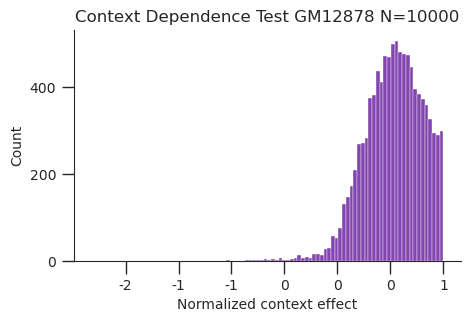

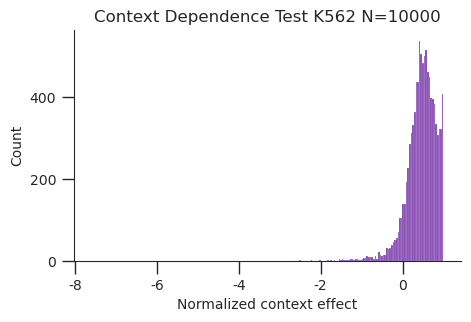

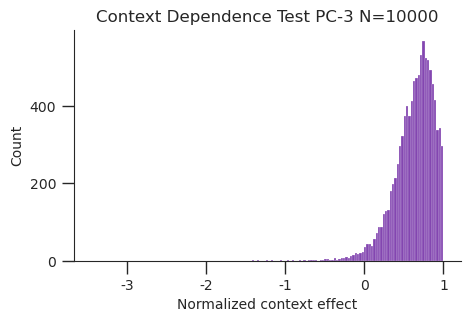

In [7]:
import matplotlib
import matplotlib.ticker as plticker


# sns.set(font_scale = 1)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
for k, df in summary_combined.groupby('cell_line'):
    
    fig = plt.figure(figsize=[5, 3])
    ax = sns.histplot(x=df['delta_mean'], color='#5A0896')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.yaxis.set_major_locator(MaxNLocator(3)) 
    # points.yaxis.set_major_locator(MaxNLocator(5)) 
    ax.yaxis.set_major_formatter(FormatStrFormatter('%i'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%i'))

    plt.xlabel('Normalized context effect') # (WT - M) / WT
    plt.title(f'Context Dependence Test {k} N={df.shape[0]}')
    fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_hist.pdf', format='pdf', dpi=300, bbox_inches='tight')


['enhancing (N=200)', 'neutral (N=110)', 'silencing (N=90)']
['enhancing (N=200)', 'neutral (N=183)', 'silencing (N=78)']
['enhancing (N=200)', 'neutral (N=200)', 'silencing (N=200)']


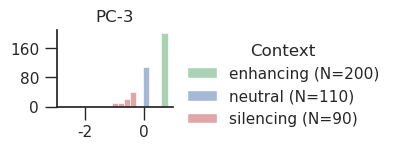

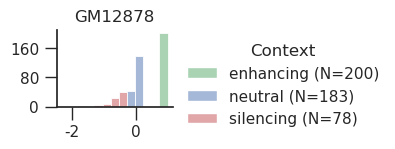

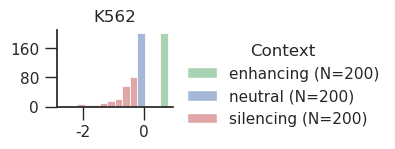

In [15]:

for k in cell_line_names:
    
    fig = plt.figure(figsize=[1.5, 1])
    sns.set(font_scale = 1.)
    sns.set_style(style='white')
    plt.rcParams['xtick.major.size'] = 9
    plt.rcParams['xtick.major.width'] = 1
    
    plt.rcParams['ytick.major.size'] = 9
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    context_df = pd.read_csv(f'{summary_csv_dir}/{k}_selected_contexts.csv').sort_values('context')


    ax = sns.histplot(data=context_df, 
                      x='delta_mean', hue='context', 
                      hue_order=['enhancing', 'neutral', 'silencing'],
                      palette=['g', 'b', 'r'])
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_major_locator(MaxNLocator(3)) 
    # points.yaxis.set_major_locator(MaxNLocator(5)) 
    ax.yaxis.set_major_formatter(FormatStrFormatter('%i'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%i'))
    # plt.legend(frameon=False);
    legend = ax.get_legend()
    handles = legend.legend_handles
    legend.remove()
    labels = [f"{c} (N={s})" for _, (c, s) in context_df.groupby('context').count().reset_index().iloc[:,:2].iterrows() 
              if 'other' not in c]
    print(labels)
    ax.legend(handles, labels,
              title='Context', frameon=False, bbox_to_anchor=[1,1])
    
    plt.ylabel('')
    plt.xlabel('')
    
    plt.title(k)

    fig.savefig(f'{pdf_dir}/{model_name}_{k}_TSS_context_effect_inset.pdf', format='pdf', dpi=300, bbox_inches='tight')


# Example sequence tracks

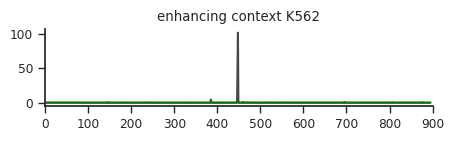

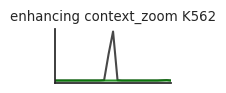

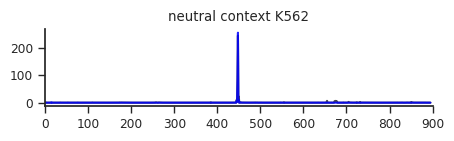

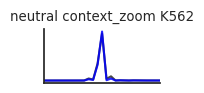

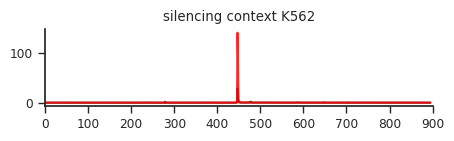

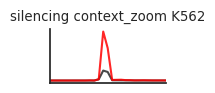

In [17]:
k = 'K562'
df = pd.read_csv(f'{summary_csv_dir}/{k}_selected_contexts.csv').sort_values('context')
cell_pred_index = cell_line_names.index(k)
color_maps = ['green', 'blue', 'red']
example_set = pd.read_csv(f'{summary_csv_dir}/example_sequences.csv')
# select most illustrative cases
for i, (name, selected_example_df) in enumerate(example_set.groupby('name')):
    color = color_maps[i]
    wt = selected_example_df['WT'].values
    mut = selected_example_df['MUT'].values

    for zoom in [None, [425, 475]]:
        if zoom:
            fig = plt.figure(figsize=[1.5, .7])
            name = name + '_zoom'
        else:
            fig = plt.figure(figsize=[5, 1])
            
        sns.set(font_scale = .8)
    
        sns.set_style(style='white')
        plt.rcParams['xtick.major.size'] = 5
        plt.rcParams['xtick.major.width'] = 1
    
        plt.rcParams['ytick.major.size'] = 5
        plt.rcParams['ytick.major.width'] = 1
        plt.rcParams['xtick.bottom'] = True
        plt.rcParams['ytick.left'] = True
    
        plt.plot(wt, 'k', alpha=0.8)
        plt.plot(mut, color=color, alpha=0.85)
        plt.xlim(0, 900)
        
        if zoom is None:
            if k == 'strong':
                plt.ylabel('TSS activity')
            if k == 'repressing CRE':
                plt.xlabel('Binned positions (128 nt)')
                
        if zoom:
            sns.set(font_scale = .8)
            plt.xticks([])
            plt.yticks([])
            plt.xlim(435, 461)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.title(f'{name} {k}')
        plt.show()
        fig.savefig(f'{pdf_dir}/{model_name}_{k}_{name}.pdf', format='pdf', dpi=300, bbox_inches='tight')


# Pairwise cell line comparison

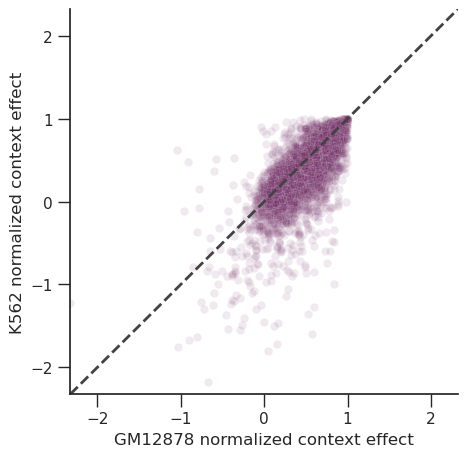

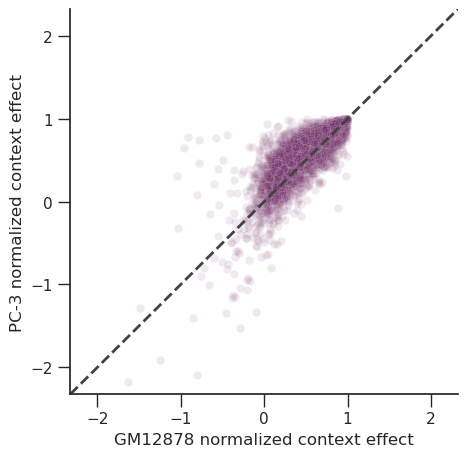

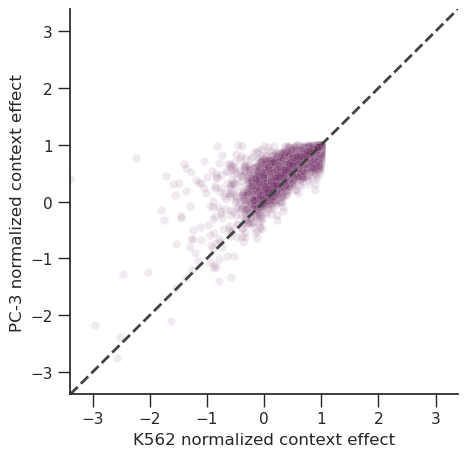

In [18]:
sns.set(font_scale = 1.)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

for (c1, df1), (c2, df2) in list(itertools.combinations([[c, df] for c, df  in summary_combined.groupby('cell_line')], 2)):
    fig = plt.figure(figsize=[5, 5])

    diff_comp = df1.merge(df2, on='seq_id', suffixes=[f'_{c1}', f'_{c2}'])
    ax=sns.scatterplot(data=diff_comp, x=f'delta_mean_{c1}', y=f'delta_mean_{c2}', edgecolors=None, color='#702963', alpha=0.1)
    min_point = np.array(diff_comp[f'delta_mean_{c1}'], diff_comp[f'delta_mean_{c2}']).min()
    # add y=x line
    plt.plot([min_point,-min_point],[min_point,-min_point], lw=2, color='#414242', linestyle='dashed')
    plt.xlabel(f'{c1} normalized context effect')
    plt.ylabel(f'{c2} normalized context effect')
    plt.xlim(min_point,-min_point)
    plt.ylim(min_point,-min_point)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(f"{pdf_dir}/pairwise_comparison_{c1}_{c2}.pdf")
    plt.show()